# Coca leaf shape

__________

The following is a `jupyter notebook` ([Kluyver et al. 2016](https://ebooks.iospress.nl/doi/10.3233/978-1-61499-649-1-87)) tutorial written using the `python` coding language. Text written in `markdown cells` is used to explain code presented and executed in `coding cells`. This tutorial assumes a working knowledge of `python` and the ability to use `jupyter notebooks`.  

If you are new to `python` or do not know how to use `jupyter notebooks`, we recommend that you familiarize yourself with them through a tutorial. For the context of plant biology and leaf shape presented here, we recommend `Plants&Python` ([VanBuren et al., 2022](https://doi.org/10.1093/plcell/koac187)), accessible using this [link](https://plantsandpython.github.io/PlantsAndPython). There you will find instructions for downloading and installing [Anaconda](https://docs.anaconda.com/anaconda/install/) and how to get going with `jupyter notebooks` and `python`.

### Import modules

We first import modules which contain functions and other code necessary to perform the analysis in this `jupyter notebook`.

Below, we provide references for some of the modules used in this notebook:  

- `pandas`, [McKinney, 2010](http://conference.scipy.org.s3.amazonaws.com/proceedings/scipy2010/pdfs/mckinney.pdf)
- `numpy`, [Harris et al., 2020](https://www.nature.com/articles/s41586-020-2649-2)
- `matplotlib`, [Hunter, 2007](https://www.computer.org/csdl/magazine/cs/2007/03/c3090/13rRUwbJD0A)
- `scikit-learn`, [Pedregosa et al., 2011](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?ref=https:/)
- `scipy`, [Virtanen et al., 2020](https://www.nature.com/articles/s41592-019-0686-2)
- `seaborn`, [Waskom, 2021](https://joss.theoj.org/papers/10.21105/joss.03021.pdf)
- `OpenCV`, [Bradski and Kaehler, 2008](https://www.google.com/books/edition/Learning_OpenCV/seAgiOfu2EIC?hl=en&gbpv=0)

In [1]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from matplotlib.colors import LogNorm

### Define functions

The following functions define useful operations used in the analysis.

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


_________
### Wild leaf data
__________

Leaf shape data from wild coca species is the same as that analyzed in [Przelomska *et al*. (2024)](https://doi.org/10.1093/molbev/msae114). 450 leaves from wild coca species were analyzed in total, including 200 *E. gracilipes*, 189 *E. cataractarum*, 43 *E. foetidum*, and 18 *E. lineolatum* leaves. Leaf shape data was saved as outline `x` and `y` coordinate data with pixels per centimeter scale information for each leaf. 

### Read in *wild* data

In [3]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./wild_metadata.csv") # read in csv

mdata.head() # head data to check

full_species species    id  px_cm
0  cataractarum    cata   151   62.0
1  cataractarum    cata  1383   76.0
2  cataractarum    cata  1422   75.0
3  cataractarum    cata  2614   58.0
4  cataractarum    cata  3565   85.0

In [4]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./wild_outlines/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['cata_13277_1.txt',
 'cata_13277_2.txt',
 'cata_13277_3.txt',
 'cata_13277_4.txt',
 'cata_13277_5.txt',
 'cata_1383_1.txt',
 'cata_1383_2.txt',
 'cata_1383_3.txt',
 'cata_1383_5.txt',
 'cata_1422_2.txt',
 'cata_1422_3.txt',
 'cata_1422_4.txt',
 'cata_1422_5.txt',
 'cata_1422_6.txt',
 'cata_151_1.txt',
 'cata_151_2.txt',
 'cata_151_3.txt',
 'cata_151_4.txt',
 'cata_151_5.txt',
 'cata_1773994_1.txt',
 'cata_1773994_2.txt',
 'cata_1773994_3.txt',
 'cata_1773994_4.txt',
 'cata_2171745_1.txt',
 'cata_2171745_2.txt',
 'cata_2171745_3.txt',
 'cata_2171745_4.txt',
 'cata_2171746_1.txt',
 'cata_2171746_2.txt',
 'cata_2171746_3.txt',
 'cata_2171746_4.txt',
 'cata_2171746_5.txt',
 'cata_2253071_1.txt',
 'cata_2253071_2.txt',
 'cata_2253071_3.txt',
 'cata_2253071_4.txt',
 'cata_2253071_5.txt',
 'cata_2458022_1.txt',
 'cata_2458022_2.txt',
 'cata_2614_1.txt',
 'cata_2614_2.txt',
 'cata_2614_3.txt',
 'cata_2614_4.txt',
 'cata_2614_5.txt',
 'cata_2690426_1.txt',
 'cata_2690426_2.txt',
 'cata_2690426

### Process and landmark *wild* data

- Read in outline
- Collect information and calculate area in centimeters squared
- Orient leaf along length by PCA 
- Find the base as the narrowest end
- Interpolate with a high resolution of pseudo-landmarks
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

Each wild coca species leaf shape outline was read in as a numpy array from text file and its scale and identification information saved to list. A principal component analysis (PCA) was used to orient the leaves along their longest axis. In order to estimate the base and tip points of the leaf, we assumed that the base of the leaf would be more pointed, and petiole-like than the wider tip. Taking 2 percent of the length of the first principal component length on each side of the leaf, we compared the width of the leaf on each side, and assigned the base to the narrower and the tip to the wider side of the leaf. We then interpolated a large number of equidistant points (10,000) around the leaf outline, assigned the base and tip index to the closest point to the estimated base and tip points, and then interpolated the desired number of equidistant pseudo-landmark points on each side of the leaf. For this study, 50 pseudo-landmarks were placed on each side of the leaf, with care taken to remove a redundant point at the tip, resulting in 99 equidistant pseudo-landmarks per leaf. Leaves were rotated so tip points upwards, scaled to centimeters, and then saved to numpy array with corresponding label information stored in a pandas dataframe.

In [5]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the percent length of the leaf to identify the tip and base
percent = 0.02

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################

# get species and herbarium id for each file
# get leaf area for each file
spe_list = [] # to store species identification
herb_id_list = [] # to store hebarium identification
cm_area_list = [] # to store the area in cm

# an array to store pseudo-landmarks
wild_cm_arr = np.zeros((len(file_names),(res*2)-1,2))

for i in range(len(file_names)): # for each leaf
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = file_names[i] # get current file name
    
    print(i, name) # print current file name for trouble shooting

    spe = name[:4] # get species name

    herb_id = name[5:-6] # get herbarium id

    lf_coords = np.loadtxt(data_dir + name) # load in leaf coordinates

    px_area = poly_area(lf_coords[:,0],lf_coords[:,1]) # calculate area in pixels

    mdata_spe = mdata[mdata["species"]==spe] # mask metadata by species
    mdata_id = mdata_spe[mdata_spe["id"]==herb_id] # mask metadata by herbarium id

    scale = float(mdata_id["px_cm"].iloc[0]) # retrieve the px per cm scale

    cm_area = px_area*(1/scale**2) # retrieve cm2 area
    
    spe_list.append(spe) # store species id
    herb_id_list.append(herb_id) # store herbarium id
    cm_area_list.append(cm_area) # store area in cm2
    
    ################################################
    ### ORIENT LEAF AND FIND BASE AND TIP POINTS ###
    ################################################
    
    pca = PCA(n_components=2) # perform PCA to align along longest axis
    pca = pca.fit_transform(lf_coords)

    left_side = pca[
        (pca[:,0])<
        np.min(pca[:,0])+((np.max(pca[:,0])-np.min(pca[:,0]))*percent)] # isolate left tip

    right_side = pca[
        (pca[:,0])>
        np.max(pca[:,0])-((np.max(pca[:,0])-np.min(pca[:,0]))*percent)] # isolate right tip

    left_height = np.abs(left_side[0,1]-left_side[-1,1]) # get left tip height

    right_height = np.abs(right_side[0,1]-right_side[-1,1]) # get right tip height

    if left_height>=right_height:
        bigger_tip=left_side
        smaller_tip=right_side
    else:
        bigger_tip=right_side
        smaller_tip=left_side

    base_pt = smaller_tip[np.abs(smaller_tip[:,0])==np.max(np.abs(smaller_tip[:,0]))][0]
    tip_pt = bigger_tip[np.abs(bigger_tip[:,0])==np.max(np.abs(bigger_tip[:,0]))][0]
    
    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(pca[:,0], 
                                           pca[:,1], high_res_pts)
    
    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)
    
    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))
    
    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))
    
    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate leaf area in pixels^2
    lf_area_px2 = poly_area(rot_pts[:,0], rot_pts[:,1])
    
    # get px_cm
    px_cm = np.sqrt(lf_area_px2/cm_area)

    # scale leaf into cm
    cm_lf = rot_pts/(px_cm)
    
    # store the leaf scaled into cm into the cm_arr
    wild_cm_arr[i,:,:] = cm_lf


0 cata_13277_1.txt
1 cata_13277_2.txt
2 cata_13277_3.txt
3 cata_13277_4.txt
4 cata_13277_5.txt
5 cata_1383_1.txt
6 cata_1383_2.txt
7 cata_1383_3.txt
8 cata_1383_5.txt
9 cata_1422_2.txt
10 cata_1422_3.txt
11 cata_1422_4.txt
12 cata_1422_5.txt
13 cata_1422_6.txt
14 cata_151_1.txt
15 cata_151_2.txt
16 cata_151_3.txt
17 cata_151_4.txt
18 cata_151_5.txt
19 cata_1773994_1.txt
20 cata_1773994_2.txt
21 cata_1773994_3.txt
22 cata_1773994_4.txt
23 cata_2171745_1.txt
24 cata_2171745_2.txt
25 cata_2171745_3.txt
26 cata_2171745_4.txt
27 cata_2171746_1.txt
28 cata_2171746_2.txt
29 cata_2171746_3.txt
30 cata_2171746_4.txt
31 cata_2171746_5.txt
32 cata_2253071_1.txt
33 cata_2253071_2.txt
34 cata_2253071_3.txt
35 cata_2253071_4.txt
36 cata_2253071_5.txt
37 cata_2458022_1.txt
38 cata_2458022_2.txt
39 cata_2614_1.txt
40 cata_2614_2.txt
41 cata_2614_3.txt
42 cata_2614_4.txt
43 cata_2614_5.txt
44 cata_2690426_1.txt
45 cata_2690426_2.txt
46 cata_2690426_3.txt
47 cata_2690426_4.txt
48 cata_2690427_1.txt
49 c

_________
### Cultivated leaf data
__________

Leaf shape data from cultivated varieties includes four types from 16 varieties. Except for Amazona, for which 19 leaves were measured, 20 leaves were measured for all other varieties, resulting in 319 cultivated leaves that were analyzed. From Ipadu types the varieties include Amazona, Boliviana Blanca, Gigante, and Trujillense Caucana; from Coca types the varieties include Bolivana Rojo, Chiparra, Chirosa, Dulce, Guayaba Roja, Patirroja, Peruana Roja, Tingo Maria, and Tingo Peruana; from Truxillense types the varieties include Crespa; and from Novogranatense types the varieties include Tingo Pajarita and Tingo Pajarita Caucana. Leaf shape data was saved as binary image files with pixels per centimeter scale information for each leaf and estimated base and tip landmark data that was manually placed using FIJI ([Schindelin et al., 2012](https://www.nature.com/articles/nmeth.2019)).

### Read in *cultivated* data

In [6]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./cultivated_metadata.csv") # read in csv

mdata.head() # head data to check

file variety full_name   type  plant leaf  px_cm  base_x  base_y  \
0  AMA1_d.tif     AMA   amazona  ipadu      1    d  28.42    95.5   180.5   
1  AMA1_c.tif     AMA   amazona  ipadu      1    c  28.42   107.0   206.0   
2  AMA1_b.tif     AMA   amazona  ipadu      1    b  28.42    94.0   203.0   
3  AMA1_a.tif     AMA   amazona  ipadu      1    a  28.42    94.5   201.5   
4  AMA4_e.tif     AMA   amazona  ipadu      4    e  28.42    85.5   203.5   

   tip_x  tip_y  
0  305.5  197.5  
1  293.5  193.5  
2  305.5  194.5  
3  306.5  191.5  
4  313.5  200.5

In [7]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./cultivated_images/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['AMA1_a.tif',
 'AMA1_b.tif',
 'AMA1_c.tif',
 'AMA1_d.tif',
 'AMA2_a.tif',
 'AMA2_b.tif',
 'AMA2_c.tif',
 'AMA2_d.tif',
 'AMA2_e.tif',
 'AMA3_a.tif',
 'AMA3_b.tif',
 'AMA3_c.tif',
 'AMA3_d.tif',
 'AMA3_e.tif',
 'AMA4_a.tif',
 'AMA4_b.tif',
 'AMA4_c.tif',
 'AMA4_d.tif',
 'AMA4_e.tif',
 'BOB1_a.tif',
 'BOB1_b.tif',
 'BOB1_c.tif',
 'BOB1_d.tif',
 'BOB1_e.tif',
 'BOB2_a.tif',
 'BOB2_b.tif',
 'BOB2_c.tif',
 'BOB2_d.tif',
 'BOB2_e.tif',
 'BOB3_a.tif',
 'BOB3_b.tif',
 'BOB3_c.tif',
 'BOB3_d.tif',
 'BOB3_e.tif',
 'BOB4_a.tif',
 'BOB4_b.tif',
 'BOB4_c.tif',
 'BOB4_d.tif',
 'BOB4_e.tif',
 'BRO1_a.tif',
 'BRO1_b.tif',
 'BRO1_c.tif',
 'BRO1_d.tif',
 'BRO1_e.tif',
 'BRO2_a.tif',
 'BRO2_b.tif',
 'BRO2_c.tif',
 'BRO2_d.tif',
 'BRO2_e.tif',
 'BRO3_a.tif',
 'BRO3_b.tif',
 'BRO3_c.tif',
 'BRO3_d.tif',
 'BRO3_e.tif',
 'BRO4_a.tif',
 'BRO4_b.tif',
 'BRO4_c.tif',
 'BRO4_d.tif',
 'BRO4_e.tif',
 'CHA1_a.tif',
 'CHA1_b.tif',
 'CHA1_c.tif',
 'CHA1_d.tif',
 'CHA1_e.tif',
 'CHA2_a.tif',
 'CHA2_b.tif',
 'CHA2_c.t

### Process and landmark *cultivated* data

- Read in image in grayscale
- Select the contour of the largest object (the leaf)
- Interpolate with a high resolution of pseudo-landmarks
- Find the base and tip index point on the high resolution contour
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

Each cultivated coca variety leaf was read in as a binary image file using the python module OpenCV ([Bradski and Kaehler, 2008](https://www.google.com/books/edition/Learning_OpenCV/seAgiOfu2EIC?hl=en&gbpv=0)). The largest contour was selected as the leaf outline and the manually placed estimations of base and tip points used to find the respective points. Otherwise, pseudo-landmarks were similarly placed for cultivated leaves as they were for wild.

In [8]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################
#################

# an array to store pseudo-landmarks
cult_cm_arr = np.zeros((len(mdata),(res*2)-1,2))

# for each leaf . . .
for lf in range(len(mdata)):

    ###############################
    ### READ IN GRAYSCALE IMAGE ###
    ###############################

    curr_image = mdata["file"][lf] # select the current image
    print(lf, curr_image) # print each leaf in case there are problems later

    # read in image
    # convert to grayscale
    # invert the binary
    img = cv2.bitwise_not(cv2.cvtColor(cv2.imread(data_dir + curr_image),cv2.COLOR_BGR2GRAY))

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ##############################
    ### SELECT LARGEST CONTOUR ###
    ##############################

    # ideally there is only one leaf in the image
    # in the case there are smaller objects
    # this code selects the largest object (the leaf)
    # if there is one and only one object in the image
    # then the following code is not necessary

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, y vals

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(np.array(sorted_x_conts[0], dtype=np.float32), 
                                           np.array(sorted_y_conts[0], dtype=np.float32), high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # get the base and tip landmark point values
    base_pt = np.array((mdata["base_x"][lf], mdata["base_y"][lf]))
    tip_pt = np.array((mdata["tip_x"][lf], mdata["tip_y"][lf]))

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)

    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))

    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))

    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate leaf area in pixels^2
    lf_area_px2 = poly_area(rot_pts[:,0], rot_pts[:,1])
    
    # get px_cm
    px_cm = mdata["px_cm"][lf]

    # scale leaf into cm
    cm_lf = rot_pts/(px_cm)
    
    # store the leaf scaled into cm into the cm_arr
    cult_cm_arr[lf,:,:] = cm_lf

0 AMA1_d.tif
1 AMA1_c.tif
2 AMA1_b.tif
3 AMA1_a.tif
4 AMA4_e.tif
5 AMA4_d.tif
6 AMA4_c.tif
7 AMA4_b.tif
8 AMA4_a.tif
9 AMA3_e.tif
10 AMA3_d.tif
11 AMA3_c.tif
12 AMA3_b.tif
13 AMA3_a.tif
14 AMA2_e.tif
15 AMA2_d.tif
16 AMA2_c.tif
17 AMA2_b.tif
18 AMA2_a.tif
19 BOB4_e.tif
20 BOB4_d.tif
21 BOB4_c.tif
22 BOB4_b.tif
23 BOB4_a.tif
24 BOB3_e.tif
25 BOB3_d.tif
26 BOB3_c.tif
27 BOB3_b.tif
28 BOB3_a.tif
29 BOB2_e.tif
30 BOB2_d.tif
31 BOB2_c.tif
32 BOB2_b.tif
33 BOB2_a.tif
34 BOB1_e.tif
35 BOB1_d.tif
36 BOB1_c.tif
37 BOB1_b.tif
38 BOB1_a.tif
39 BRO4_e.tif
40 BRO4_d.tif
41 BRO4_c.tif
42 BRO4_b.tif
43 BRO4_a.tif
44 BRO3_e.tif
45 BRO3_d.tif
46 BRO3_c.tif
47 BRO3_b.tif
48 BRO3_a.tif
49 BRO2_e.tif
50 BRO2_d.tif
51 BRO2_c.tif
52 BRO2_b.tif
53 BRO2_a.tif
54 BRO1_e.tif
55 BRO1_d.tif
56 BRO1_c.tif
57 BRO1_b.tif
58 BRO1_a.tif
59 CHA4_e.tif
60 CHA4_d.tif
61 CHA4_c.tif
62 CHA4_b.tif
63 CHA4_a.tif
64 CHA3_e.tif
65 CHA3_d.tif
66 CHA3_c.tif
67 CHA3_b.tif
68 CHA3_a.tif
69 CHA2_e.tif
70 CHA2_d.tif
71 CHA2_c.tif
72

_______
### Combine cultivated and wild data

Once pseudo-landmark points had been placed along rotated and scaled wild species and cultivated varieties leaves, the point data was combined into a single numpy array and the associated labels into a single pandas dataframe for further analysis.

In [9]:
# lists to store different names
short_name_list = []
full_name_list = []
type_name_list = []

for i in range(len(spe_list)): # for each wild species
    
    spe = spe_list[i] # select the current species
    
    if spe=="cata": # assign the short name, full_name, and type
        short = "wild_CATA"
        full = "wild_cataractarum"
        typ = "wild_cataractarum"
        
    elif spe=="foet":
        short = "wild_FOET"
        full = "wild_foetidum"
        typ = "wild_foetidum"
        
    elif spe=="grac":
        short = "wild_GRAC"
        full = "wild_gracilipes"
        typ = "wild_gracilipes"
        
    elif spe=="line":
        short = "wild_LINE"
        full = "wild_lineolatum"
        typ = "wild_lineolatum"
        
    short_name_list.append(short) # store names
    full_name_list.append(full)
    type_name_list.append(typ)

# create a dataframe of wild names
wild_names = pd.DataFrame(
    {
        "short_name":short_name_list,
        "full_name":full_name_list,
        "type_name":type_name_list
    })

# create a dataframe of cultivated names
cult_names = mdata.iloc[:,1:4]

# rename column names to match for concatenating by row
cult_names = cult_names.rename(columns={
    "variety":"short_name",
    "full_name":"full_name",
    "type":"type_name"
    
})


# concatenate cultivated and wild dataframes
all_mdata = pd.concat([cult_names, wild_names], axis=0).reset_index(drop=True)

# concatenate cultivated and wild landmark centimeter arrays
all_cm_arr = np.row_stack((cult_cm_arr, wild_cm_arr))


### Check by plotting random leaves

To visually inspect differences between varities and to insure the accuracy of the pseudo-landmark placement method, random leaves from each wild species and cultivated variety type were plotted.

In [10]:
# create a list of the order we want to plot

type_order = [

"amazona","boliviana blanca","gigante","tujillense caucana", # ipadu --#trujillense caucana is misspelled--
"boliviana rojo","chiparra","chirosa","dulce","guayaba roja","patirroja","peruana roja","tingo maria","tingo peruana", #coca
"crespa", # truxillense
"tingo pajarita", "tingo pajarita caucana", # novogranatense
'wild_cataractarum', 'wild_foetidum', 'wild_gracilipes', 'wild_lineolatum'] # wild species

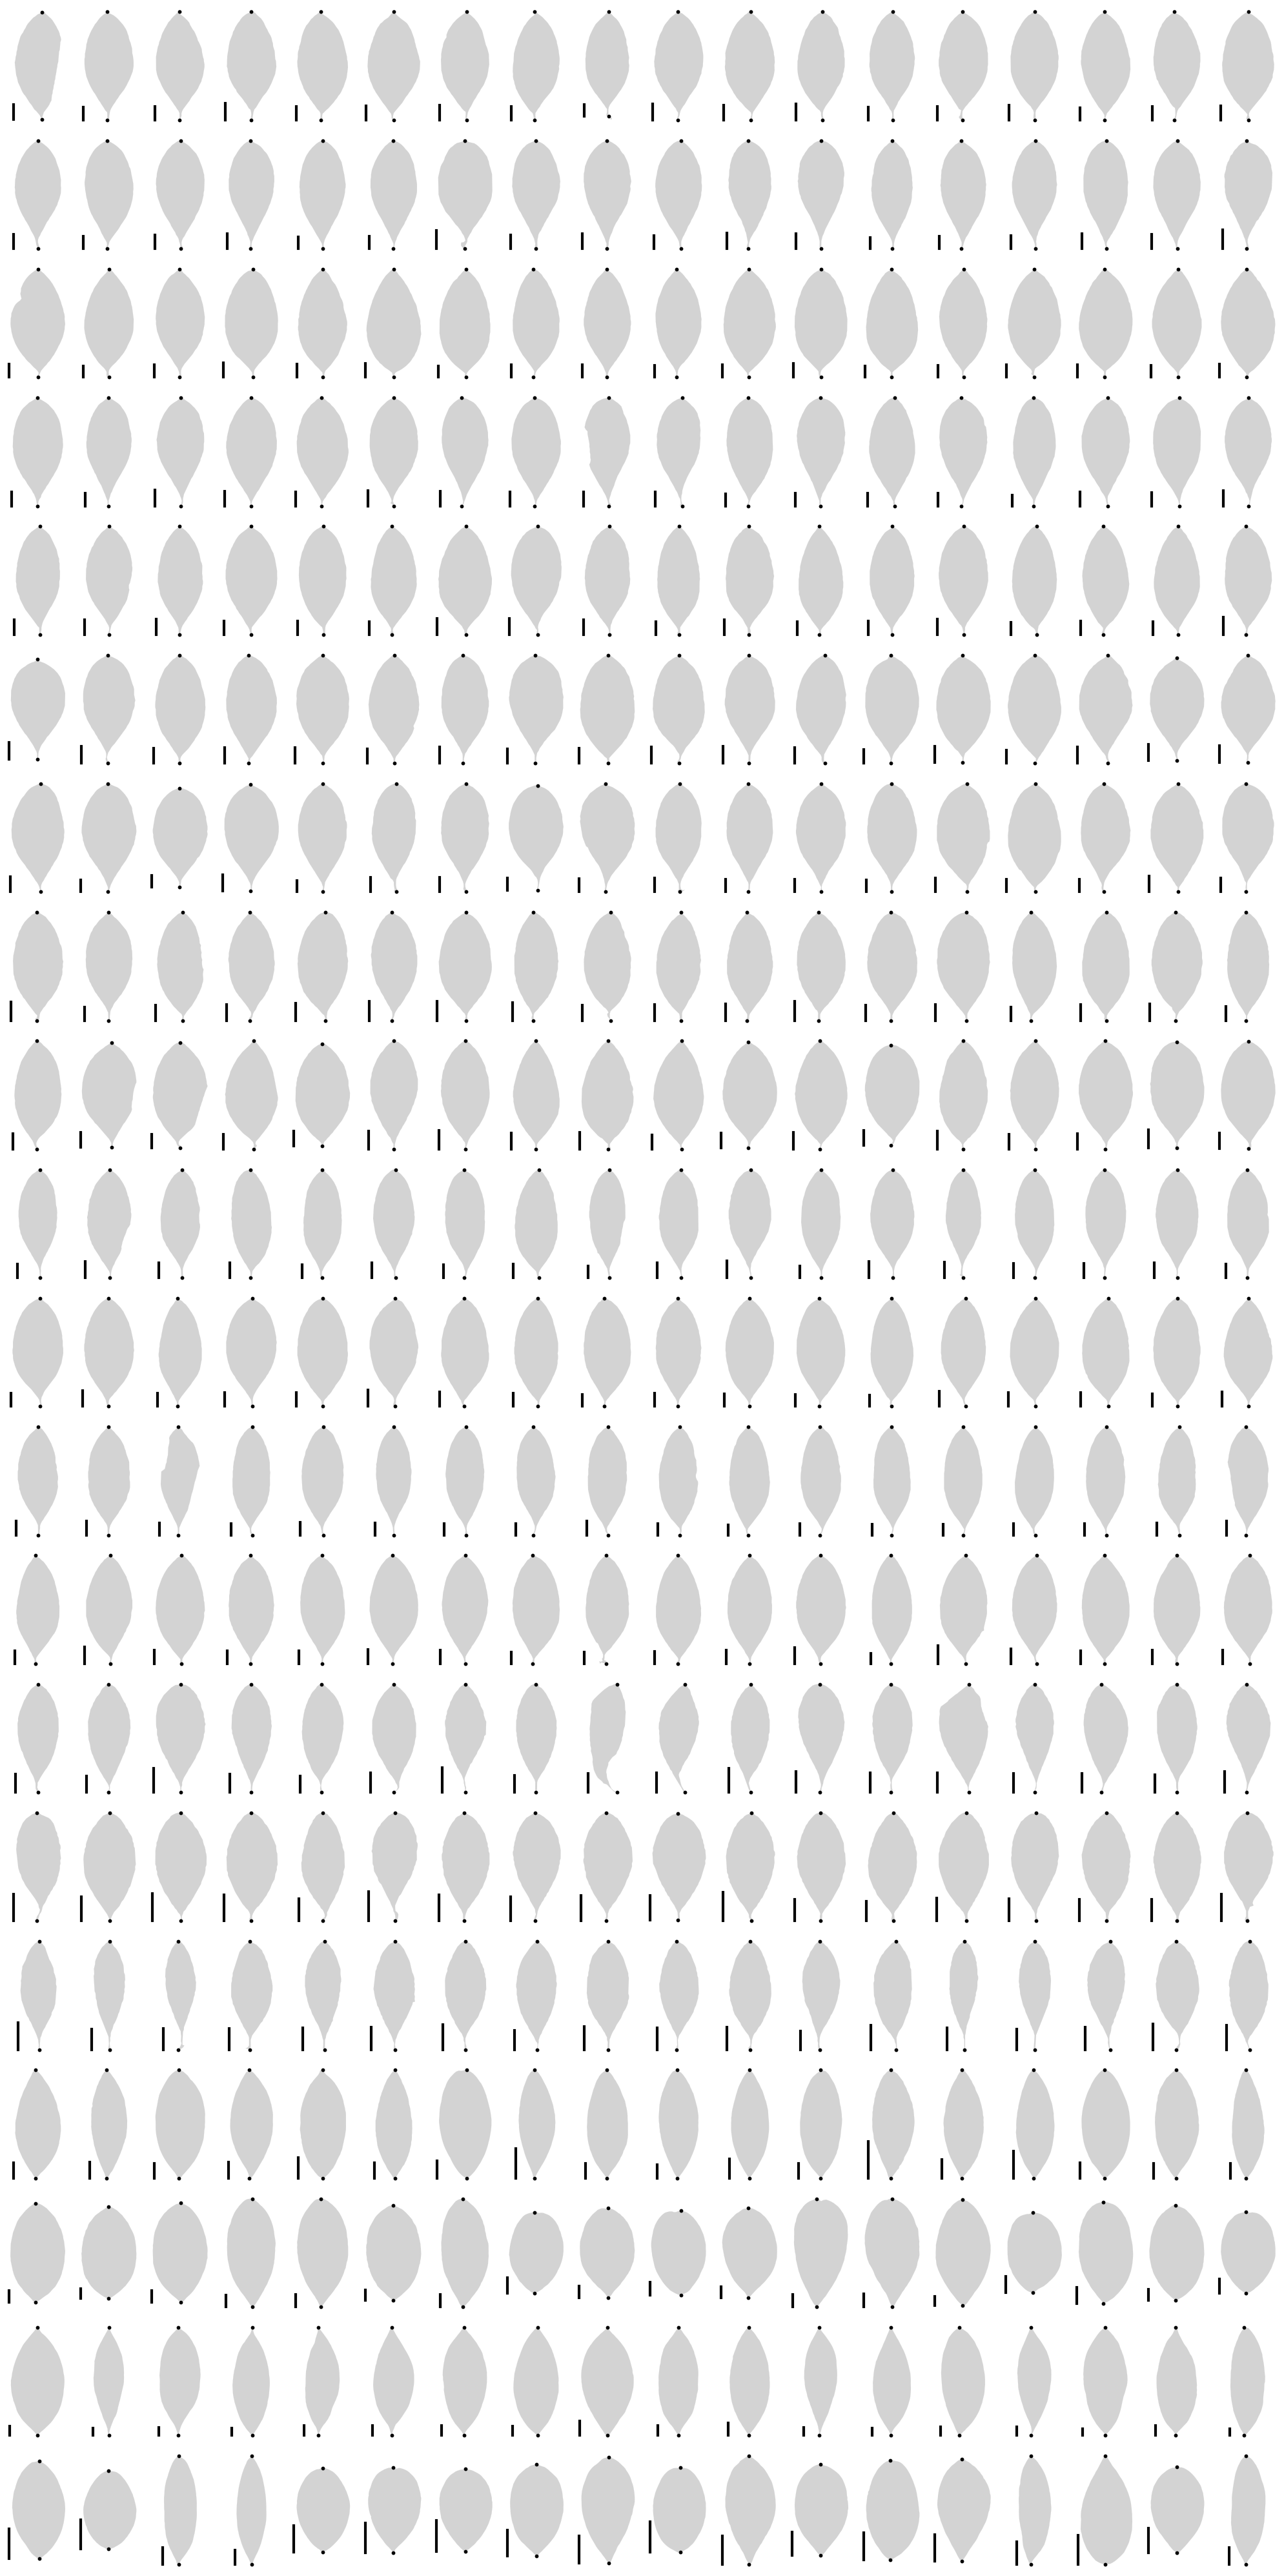

In [11]:
plt.figure(figsize=(20,40)) # set figure size

counter = 1 # set counter for subplot initially to 1

for i in range(len(type_order)): # for each coca type

    curr_type = type_order[i] # select current type

    curr_df = all_mdata[all_mdata["full_name"]==curr_type] # mask dataframe for current type
    
    indices = curr_df.sample(18, random_state=42).index # select 18 random indices
    
    curr_arr = all_cm_arr[indices,:,:] # retrieve point data for current leaves
    
    for j in range(len(curr_arr)): # for each of 18 leaves of current type, plot
    
        plt.subplot(20,18,counter)
        plt.fill(curr_arr[j,:,0], curr_arr[j,:,1], c="lightgray", lw=0.1) # outline
        plt.plot([min(curr_arr[j,:,0])-0.1,min(curr_arr[j,:,0])-0.1],[curr_arr[j,0,1], curr_arr[j,0,1]+1], c="k", lw=3) # cm scale
        plt.scatter(curr_arr[j,0,0], curr_arr[j,0,1], s=10, c="k") # base
        plt.scatter(curr_arr[j,res-1,0], curr_arr[j,res-1,1], s=10, c="k") # tip
        plt.gca().set_aspect("equal")
        plt.gca().set_axis_off()
        counter+=1

plt.tight_layout()

#plt.savefig("random_leaves.png")

### Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards and scaled in centimeters, the following dimensions were calculated: width, as the difference in centimeters between minimum and maximum x values in an oriented leaf; length, as the difference in centimeters between minimum and maximum y values in an oriented leaf, and area was calculated from the area of the polygon.

In [12]:
# lists to store variables
width_list = []
length_list = []
area_list = []
solidity_list = []
asymmetry_list = []

# for each leaf . . .
for lf in range(len(all_cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = all_cm_arr[lf,:,:] # select current leaf
    
    ############################
    ### CALCULATE DIMENSIONS ###
    ############################
    
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calcualte area
    
    ##########################
    ### CALCULATE SOLIDITY ###
    ##########################
    
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity
    
    ##########################
    ### CALCULATE SYMMETRY ###
    ##########################
    
    left_side = curr_lf[:(res-1)+1,] # isolate left side of leaf
    right_side = curr_lf[(res-1):,] # isolate right side of leaf
    right_side = right_side[::-1] # reverse the right side to align indices with left

    # calculate procrustes distance between left and right side of leaf
    s1, s2, distance = procrustes(left_side, right_side) 
    
    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    solidity_list.append(solidity)
    asymmetry_list.append(distance)
    
# add data to the mdata dataframe
all_mdata["width"] = width_list
all_mdata["length"] = length_list
all_mdata["area"] = area_list
all_mdata["solidity"] = solidity_list
all_mdata["asymmetry"] = asymmetry_list
    

### Pair plots by types

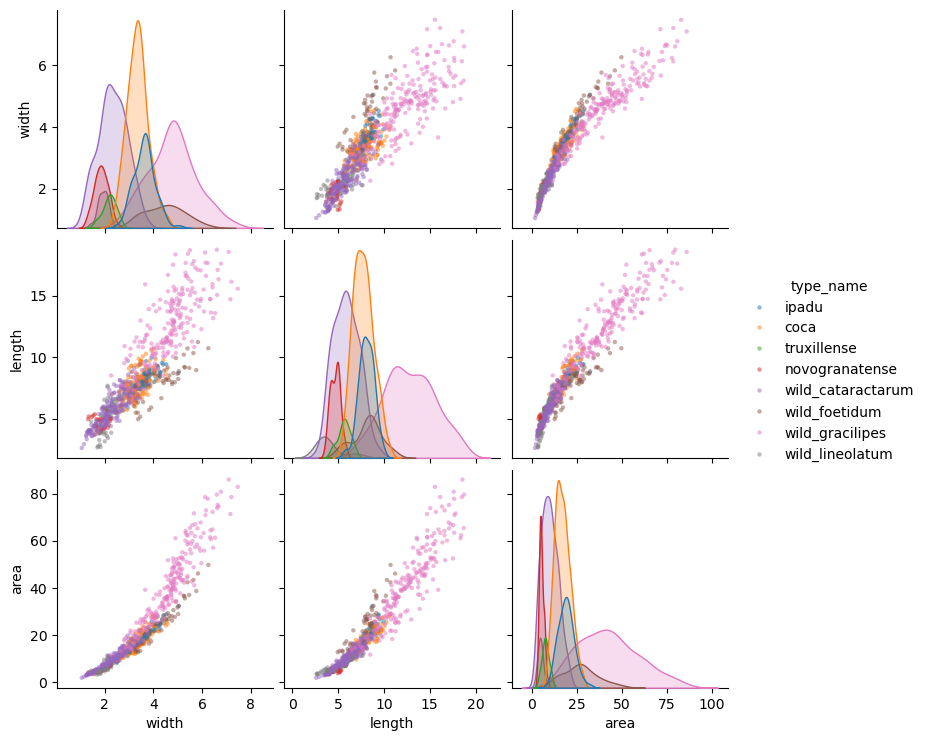

In [13]:
sns.pairplot(all_mdata,
             x_vars=["width", "length", "area"],
             y_vars=["width", "length", "area"],
             hue="type_name",
             plot_kws={"s": 10, "alpha":0.5, "lw":0}
            )


### Allometry

To analyze allometry, or changes in relative leaf dimensions with respect to size, linear models were calculated for length as a function of width using the numpy `polyfit()` and `poly1d` functions. Length was modeled as a function of width to the least to most wide leaf for each cultivated variety type and wild species and plotted on a log-scaled axis.

In [14]:
# ipadu
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="ipadu"],
                   all_mdata["length"][all_mdata["type_name"]=="ipadu"],
                  1)
ipadu_func = np.poly1d(coefs)
ipadu_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="ipadu"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="ipadu"]), 100)


# coca
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="coca"],
                   all_mdata["length"][all_mdata["type_name"]=="coca"],
                  1)
coca_func = np.poly1d(coefs)
coca_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="coca"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="coca"]), 100)

# truxillense
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="truxillense"],
                   all_mdata["length"][all_mdata["type_name"]=="truxillense"],
                  1)
truxillense_func = np.poly1d(coefs)
truxillense_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="truxillense"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="truxillense"]), 100)

# novogranatense
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="novogranatense"],
                   all_mdata["length"][all_mdata["type_name"]=="novogranatense"],
                  1)
novogranatense_func = np.poly1d(coefs)
novogranatense_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="novogranatense"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="novogranatense"]), 100)

# cataractarum
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="wild_cataractarum"],
                   all_mdata["length"][all_mdata["type_name"]=="wild_cataractarum"],
                  1)
cataractarum_func = np.poly1d(coefs)
cataractarum_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="wild_cataractarum"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="wild_cataractarum"]), 100)

# foetidum
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="wild_foetidum"],
                   all_mdata["length"][all_mdata["type_name"]=="wild_foetidum"],
                  1)
foetidum_func = np.poly1d(coefs)
foetidum_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="wild_foetidum"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="wild_foetidum"]), 100)

# gracilipes
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="wild_gracilipes"],
                   all_mdata["length"][all_mdata["type_name"]=="wild_gracilipes"],
                  1)
gracilipes_func = np.poly1d(coefs)
gracilipes_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="wild_gracilipes"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="wild_gracilipes"]), 100)

# lineolatum
coefs = np.polyfit(all_mdata["width"][all_mdata["type_name"]=="wild_lineolatum"],
                   all_mdata["length"][all_mdata["type_name"]=="wild_lineolatum"],
                  1)
lineolatum_func = np.poly1d(coefs)
lineolatum_xvals = np.linspace(np.min(all_mdata["width"][all_mdata["type_name"]=="wild_lineolatum"]),
                         np.max(all_mdata["width"][all_mdata["type_name"]=="wild_lineolatum"]), 100)

# x and y vals for one-to-one line
xvals = np.linspace(np.min(all_mdata["width"]),
                         np.max(all_mdata["width"]), 100)
yvals = xvals

Plot length vs width on a log scale and lines for each species/type

Text(0, 0.5, 'length, cm')

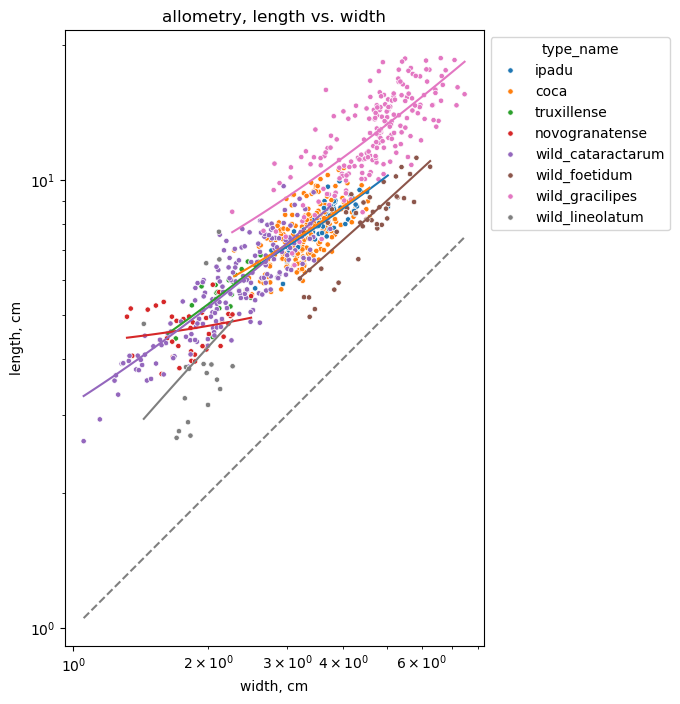

In [15]:
plt.figure(figsize=(8,8)) # set figure size

ax = sns.scatterplot(data=all_mdata, x="width", y="length", hue="type_name", linewidth=0.5, s=15) # plot

# plot allometric lines
plt.plot(ipadu_xvals, ipadu_func(ipadu_xvals))
plt.plot(coca_xvals, coca_func(coca_xvals))
plt.plot(truxillense_xvals, truxillense_func(truxillense_xvals))
plt.plot(novogranatense_xvals, novogranatense_func(novogranatense_xvals))
plt.plot(cataractarum_xvals, cataractarum_func(cataractarum_xvals))
plt.plot(foetidum_xvals, foetidum_func(foetidum_xvals))
plt.plot(gracilipes_xvals, gracilipes_func(gracilipes_xvals))
plt.plot(lineolatum_xvals, lineolatum_func(lineolatum_xvals))

# plot one-to-one line
plt.plot(xvals, yvals, c="gray", linestyle="dashed")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # move legend outside plot
plt.xscale("log") # x axis log scale
plt.yscale("log") # y axis log scale
plt.gca().set_aspect("equal") # equal aspect ratio
plt.title("allometry, length vs. width") # title
plt.xlabel("width, cm") # x axis title
plt.ylabel("length, cm") # y axis title

### Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

Procrustean alignment was carried out for all leaves together. To superimpose contours by minimizing the overall distance between pseudo-landmark values through the functions of translation, scaling, rotation, and reflection, a generalized Procrustes analysis (GPA) is used ([Gower, 1975](https://link.springer.com/article/10.1007/BF02291478)). A function was defined to calculate a GPA mean. To calculate the GPA mean, an arbitrary leaf is first chosen and all other leaves are aligned to it using Procrustean superimposition. A mean from the aligned shapes is calculated, which is used as the reference shape for alignment in the next iteration. The algorithm stops when the Procrustes distance between means calculated between two successive iterations falls below an arbitrarily low value. All leaves are then aligned to the final GPA mean shape. The Procrustean superimposition was visualized for all leaves by plotting each leaf with high transparency together with overall GPA mean and for each cultivated type and each wild species with respect to group means.

In [16]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(all_cm_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(all_cm_arr)) 

for i in range(len(all_cm_arr)):
    s1, s2, distance = procrustes(mean_shape, all_cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

Visualize all leaves plotted against the mean Procrustes leaf

Text(0.5, 1.0, 'overall mean leaf')

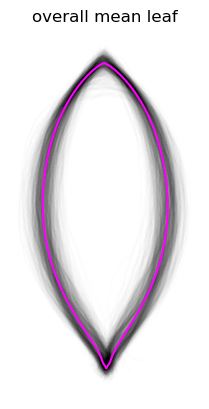

In [17]:
for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.006)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall mean leaf")

Text(0.5, 1.0, 'lineolatum')

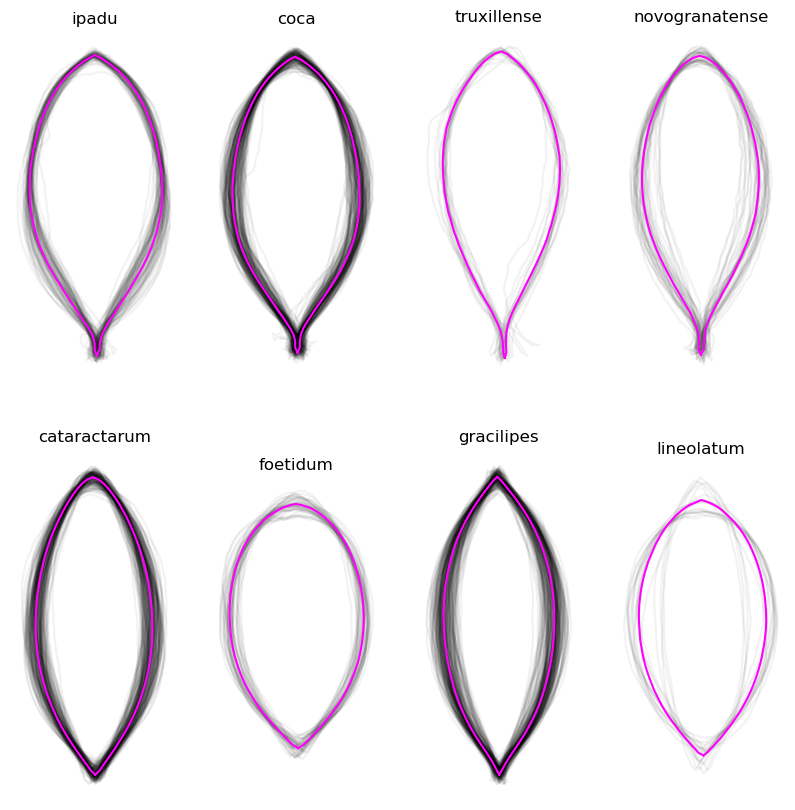

In [18]:
# create arrays for each type
ipadu_arr = proc_arr[all_mdata[all_mdata["type_name"]=="ipadu"].index.values,:,:]

coca_arr = proc_arr[all_mdata[all_mdata["type_name"]=="coca"].index.values,:,:]
truxillense_arr = proc_arr[all_mdata[all_mdata["type_name"]=="truxillense"].index.values,:,:]
novogranatense_arr = proc_arr[all_mdata[all_mdata["type_name"]=="novogranatense"].index.values,:,:]
cataractarum_arr = proc_arr[all_mdata[all_mdata["type_name"]=="wild_cataractarum"].index.values,:,:]
foetidum_arr = proc_arr[all_mdata[all_mdata["type_name"]=="wild_foetidum"].index.values,:,:]
gracilipes_arr = proc_arr[all_mdata[all_mdata["type_name"]=="wild_gracilipes"].index.values,:,:]
lineolatum_arr = proc_arr[all_mdata[all_mdata["type_name"]=="wild_lineolatum"].index.values,:,:]


lf_alpha = 0.05
plt.figure(figsize=(10,10))

plt.subplot(2,4,1)
for i in range(len(ipadu_arr)):
    plt.plot(ipadu_arr[i,:,0], ipadu_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(ipadu_arr, axis=0)[:,0], np.mean(ipadu_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("ipadu")

plt.subplot(2,4,2)
for i in range(len(coca_arr)):
    plt.plot(coca_arr[i,:,0], coca_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(coca_arr, axis=0)[:,0], np.mean(coca_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("coca")

plt.subplot(2,4,3)
for i in range(len(truxillense_arr)):
    plt.plot(truxillense_arr[i,:,0], truxillense_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(truxillense_arr, axis=0)[:,0], np.mean(truxillense_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("truxillense")

plt.subplot(2,4,4)
for i in range(len(novogranatense_arr)):
    plt.plot(novogranatense_arr[i,:,0], novogranatense_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(novogranatense_arr, axis=0)[:,0], np.mean(novogranatense_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("novogranatense")

plt.subplot(2,4,5)
for i in range(len(cataractarum_arr)):
    plt.plot(cataractarum_arr[i,:,0], cataractarum_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(cataractarum_arr, axis=0)[:,0], np.mean(cataractarum_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("cataractarum")

plt.subplot(2,4,6)
for i in range(len(foetidum_arr)):
    plt.plot(foetidum_arr[i,:,0], foetidum_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(foetidum_arr, axis=0)[:,0], np.mean(foetidum_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("foetidum")

plt.subplot(2,4,7)
for i in range(len(gracilipes_arr)):
    plt.plot(gracilipes_arr[i,:,0], gracilipes_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(gracilipes_arr, axis=0)[:,0], np.mean(gracilipes_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("gracilipes")

plt.subplot(2,4,8)
for i in range(len(lineolatum_arr)):
    plt.plot(lineolatum_arr[i,:,0], lineolatum_arr[i,:,1], c="k", alpha=lf_alpha)
plt.plot(np.mean(lineolatum_arr, axis=0)[:,0], np.mean(lineolatum_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("lineolatum")


### Morphospace and Linear Discriminant Analysis by type

Visualize a morphospace and classify leaves by the factor of genotype

- Plot a morphospace using the inverse transform of the PCA
- Perform a Linear Discriminant Analysis
- Visualize LDA results as a confusion matrix
- Plot out LDA scores

A morphospace was created and visualized using principal component analysis (PCA) and the inverse PCA transform. To determine the variance associated with each principal component (PC), PCA was first performed with the maximum number of PCs, which in this case is twice the pseudo-landmark number (the number of coordinate values). PCA was fitted again using only 2 PCs for simplicity of morphospace visualization. Along regular intervals of PC1 and PC2 the inverse transform was used to visualize representative leaves, or so-called `eigenleaves`. Data was projected back onto the calcualted PCA and morphospace. A linear discriminant analysis (LDA) model was fitted modeling 198 coordinate values as a function of leaf class. Confusion matrices and LDA scores were calculated by projecting samples back onto the fitted model.

In [19]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 198 # PC number = not number of leaves, but features
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 65.4%, 65.4%
PC2: 21.2%, 86.6%
PC3: 4.4%, 90.9%
PC4: 2.4%, 93.3%
PC5: 2.0%, 95.3%
PC6: 0.9%, 96.3%
PC7: 0.7%, 96.9%
PC8: 0.6%, 97.6%
PC9: 0.4%, 98.0%
PC10: 0.3%, 98.3%
PC11: 0.3%, 98.5%
PC12: 0.2%, 98.7%
PC13: 0.1%, 98.9%
PC14: 0.1%, 99.0%
PC15: 0.1%, 99.1%
PC16: 0.1%, 99.2%
PC17: 0.1%, 99.3%
PC18: 0.1%, 99.3%
PC19: 0.1%, 99.4%
PC20: 0.0%, 99.4%
PC21: 0.0%, 99.5%
PC22: 0.0%, 99.5%
PC23: 0.0%, 99.5%
PC24: 0.0%, 99.6%
PC25: 0.0%, 99.6%
PC26: 0.0%, 99.6%
PC27: 0.0%, 99.6%
PC28: 0.0%, 99.7%
PC29: 0.0%, 99.7%
PC30: 0.0%, 99.7%
PC31: 0.0%, 99.7%
PC32: 0.0%, 99.7%
PC33: 0.0%, 99.7%
PC34: 0.0%, 99.7%
PC35: 0.0%, 99.7%
PC36: 0.0%, 99.8%
PC37: 0.0%, 99.8%
PC38: 0.0%, 99.8%
PC39: 0.0%, 99.8%
PC40: 0.0%, 99.8%
PC41: 0.0%, 99.8%
PC42: 0.0%, 99.8%
PC43: 0.0%, 99.8%
PC44: 0.0%, 99.8%
PC45: 0.0%, 99.8%
PC46: 0.0%, 99.8%
PC47: 0.0%, 99.8%
PC48: 0.0%, 99.8%
PC49: 0.0%, 99.8%
PC50: 0.0%, 99.8%
PC51: 0.0%, 99.8%
PC52: 0.0%, 99.9%
PC53: 0.0%, 99.9%
PC54: 0.0%, 99.9%
PC55: 0.0%, 99.9%

In [20]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # keep to 2 for now for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
all_mdata["PC1"] = PCs[:,0]
all_mdata["PC2"] = PCs[:,1]
    

PC: var, overall 
PC1: 65.4%, 65.4%
PC2: 21.2%, 86.6%


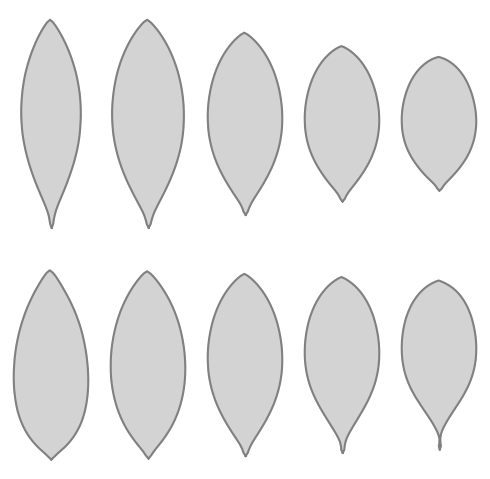

In [21]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 2 PCs ###
###################################################

# calculate standard deviations for each PC
PC1_std = all_mdata["PC1"].std()
PC2_std = all_mdata["PC2"].std()

# create list of lists of PC values to reconstruct
PC_vals = [[-2*PC1_std,0],
           [-1*PC1_std,0],
           [0*PC1_std,0],
           [1*PC1_std,0],
           [2*PC1_std,0],
           [0,-2*PC2_std],
           [0,-1*PC2_std],
           [0,0*PC2_std],
           [0,1*PC2_std],
           [0,2*PC2_std],
]

plt.figure(figsize=(5,5))

counter = 1

for i in range(len(PC_vals)):
    
    # create inverse leaf
    inv_leaf = pca.inverse_transform(np.array(PC_vals[i]))
    inv_x = inv_leaf[0::2] # select just inverse x vals
    inv_y = inv_leaf[1::2] # select just inverse y vals
    
    # plot inverse leaf
    plt.subplot(2,5,counter)
    plt.fill(inv_x, inv_y, c="lightgray")
    plt.plot(inv_x, inv_y, c="gray")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    counter += 1

plt.tight_layout()

Text(0.5, 1.0, 'Procrustean morphospace')

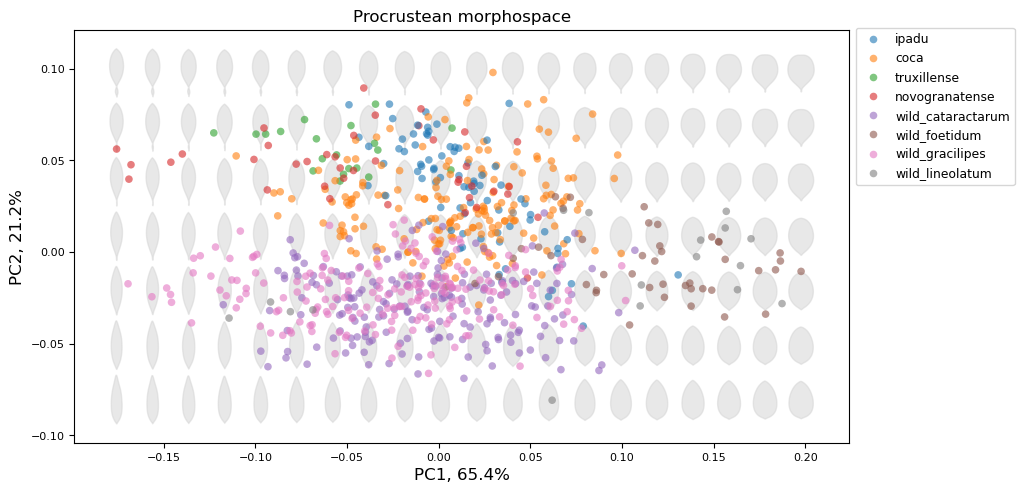

In [28]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 20 # set number of PC1 intervals
numPC2 = 7 # set number of PC2 intervals
hue = "type_name" # select the factor to color by
s = 0.08 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 30 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=all_mdata, x="PC1", y="PC2", hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)

The number of falsely predicted: 42
The number of correctly predicted: 727
Out of 769 total samples


Text(98.08159722222221, 0.5, 'Actual class')

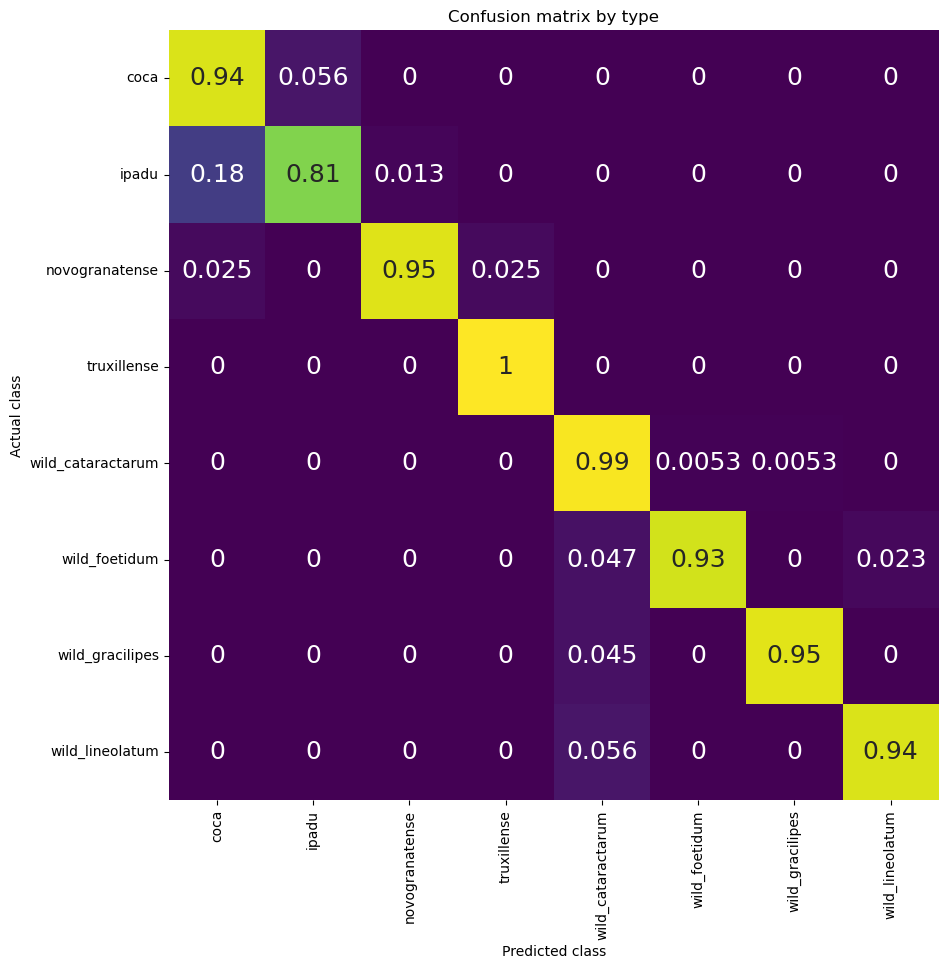

In [29]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# create a df for LDA by type name
type_df = pd.DataFrame(data=flat_arr[:,:])

# add the type name labels
type_df["type_name"] = all_mdata["type_name"]

# create input and output variables
X = type_df.iloc[:,0:((res*2)-1)*2]
y = type_df["type_name"]

# fit the LDA model
type_model = LinearDiscriminantAnalysis()
type_model.fit(X,y)

# retrieve LDA scalings and coefficients
type_scalings = type_model.scalings_
type_coefs = type_model.coef_

# perform prediction
type_prediction = type_model.predict(X)
comparison_result = [X == y for X, y in zip(y, type_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_type_values = all_mdata["type_name"]
predicted_type_values = type_prediction

cm_type = confusion_matrix(true_type_values, predicted_type_values, normalize="true")
cm_type = cm_type / cm_type.sum(axis=1)

classes = np.sort(all_mdata["type_name"].unique())

# Confusion matrix

plt.figure(figsize=(10,10))

sns.heatmap(cm_type, 
            annot=True, 
            annot_kws={"fontsize":18}, 
            #fmt="d", 
            cmap="viridis", 
            square=True, 
            cbar=False,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by type")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")



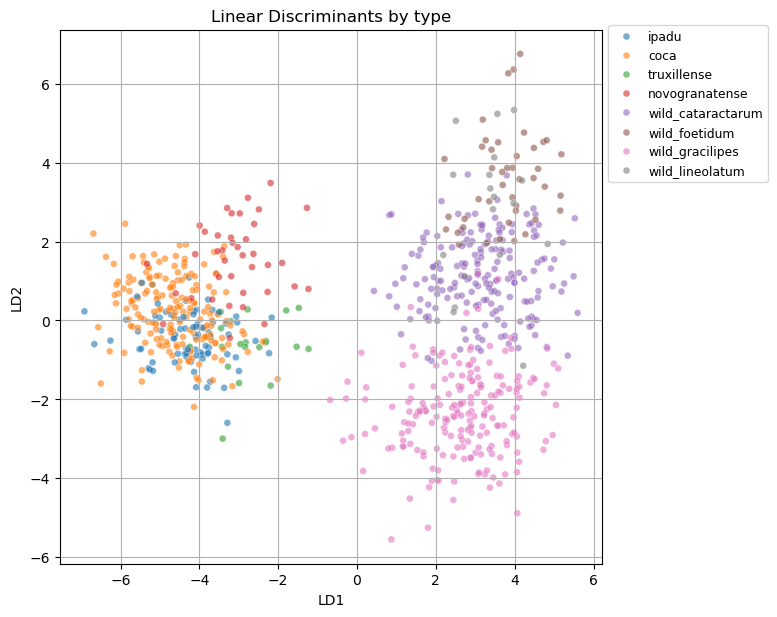

In [32]:
# Plot of linear discriminant scores by type

data_plot = type_model.fit(X, y).transform(X)
type_plot_df = pd.DataFrame(data=data_plot[:,:])
type_plot_df["type"] = all_mdata["type_name"]

type_plot_df = type_plot_df.rename(columns={0:'LD1', 1:'LD2'})

plt.figure(figsize=(7,7))
sns.scatterplot(data=type_plot_df, x="LD1", y="LD2", hue="type", s=25, alpha=0.6)
plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})

plt.title("Linear Discriminants by type")
plt.gca().set_aspect("equal")
plt.grid()

______
### Cultivated analysis
________

To compare only cultivated leaf varieties against each other, Procrustes-aligned leaf data was averaged for each variety. Hierarchical clustering was performed to group similar average leaf types with each other. The mean leaf for each variety was compared against the mean leaf for every other variety, where the differences of the other variety were magnified by a factor of three against the reference variety.

In [35]:
# mask out wild species
mdata = all_mdata[all_mdata["full_name"]!="wild_gracilipes"]
mdata = mdata[mdata["full_name"]!="wild_cataractarum"]
mdata = mdata[mdata["full_name"]!="wild_foetidum"]
mdata = mdata[mdata["full_name"]!="wild_lineolatum"]

### Compare average outlines to each other

In [36]:
C00_chirosa_arr = proc_arr[all_mdata[all_mdata["full_name"]=="chirosa"].index.values,:,:]
C01_chiparra_arr = proc_arr[all_mdata[all_mdata["full_name"]=="chiparra"].index.values,:,:]
I02_trujillense_caucana_arr = proc_arr[all_mdata[all_mdata["full_name"]=="tujillense caucana"].index.values,:,:]
I03_boliviana_blanca_arr = proc_arr[all_mdata[all_mdata["full_name"]=="boliviana blanca"].index.values,:,:]
N04_tingo_pajarita_arr = proc_arr[all_mdata[all_mdata["full_name"]=="tingo pajarita"].index.values,:,:]
C05_guayaba_roja_arr = proc_arr[all_mdata[all_mdata["full_name"]=="guayaba roja"].index.values,:,:]
I06_gigante_arr = proc_arr[all_mdata[all_mdata["full_name"]=="gigante"].index.values,:,:]
C07_peruana_roja_arr = proc_arr[all_mdata[all_mdata["full_name"]=="peruana roja"].index.values,:,:]
C08_boliviana_roja_arr = proc_arr[all_mdata[all_mdata["full_name"]=="boliviana rojo"].index.values,:,:]
C09_tingo_peruana_arr = proc_arr[all_mdata[all_mdata["full_name"]=="tingo peruana"].index.values,:,:]
C10_dulce_arr = proc_arr[all_mdata[all_mdata["full_name"]=="dulce"].index.values,:,:]
I11_amazona_arr = proc_arr[all_mdata[all_mdata["full_name"]=="amazona"].index.values,:,:]
N12_tingo_pajarita_caucana_arr = proc_arr[all_mdata[all_mdata["full_name"]=="tingo pajarita caucana"].index.values,:,:]
T13_crespa_arr = proc_arr[all_mdata[all_mdata["full_name"]=="crespa"].index.values,:,:]
C14_tingo_maria_arr = proc_arr[all_mdata[all_mdata["full_name"]=="tingo maria"].index.values,:,:]
C15_patirroja_arr = proc_arr[all_mdata[all_mdata["full_name"]=="patirroja"].index.values,:,:]

array_list = [
    C00_chirosa_arr,
    C01_chiparra_arr,
    I02_trujillense_caucana_arr,
    I03_boliviana_blanca_arr,
    N04_tingo_pajarita_arr,
    C05_guayaba_roja_arr,
    I06_gigante_arr,
    C07_peruana_roja_arr,
    C08_boliviana_roja_arr,
    C09_tingo_peruana_arr,
    C10_dulce_arr,
    I11_amazona_arr,
    N12_tingo_pajarita_caucana_arr,
    T13_crespa_arr,
    C14_tingo_maria_arr,
    C15_patirroja_arr
]

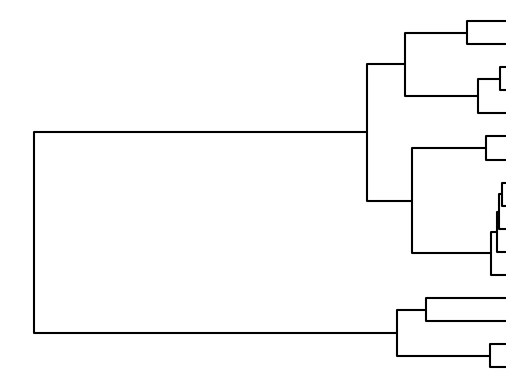

In [46]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage

# create a custom Procrustes distance array
distance_array = np.zeros((16,16))

for i in range(len(array_list)):
    for j in range(len(array_list)):
        
        arr1 = array_list[i]
        arr2 = array_list[j]
        
        s1, s2, distance = procrustes(np.mean(arr1, axis=0), np.mean(arr2, axis=0))
        distance_array[i,j] = distance

# convert custom Procrustes array for linkage
distArray = ssd.squareform(distance_array, checks=False) # distArray[{n choose 2}-{n-i choose 2}

# perform linkage
Z = linkage(distArray, method="average")

# plot dendrogram
dendrogram(Z, orientation="left", color_threshold=0, above_threshold_color='k')
plt.gca().set_axis_off()


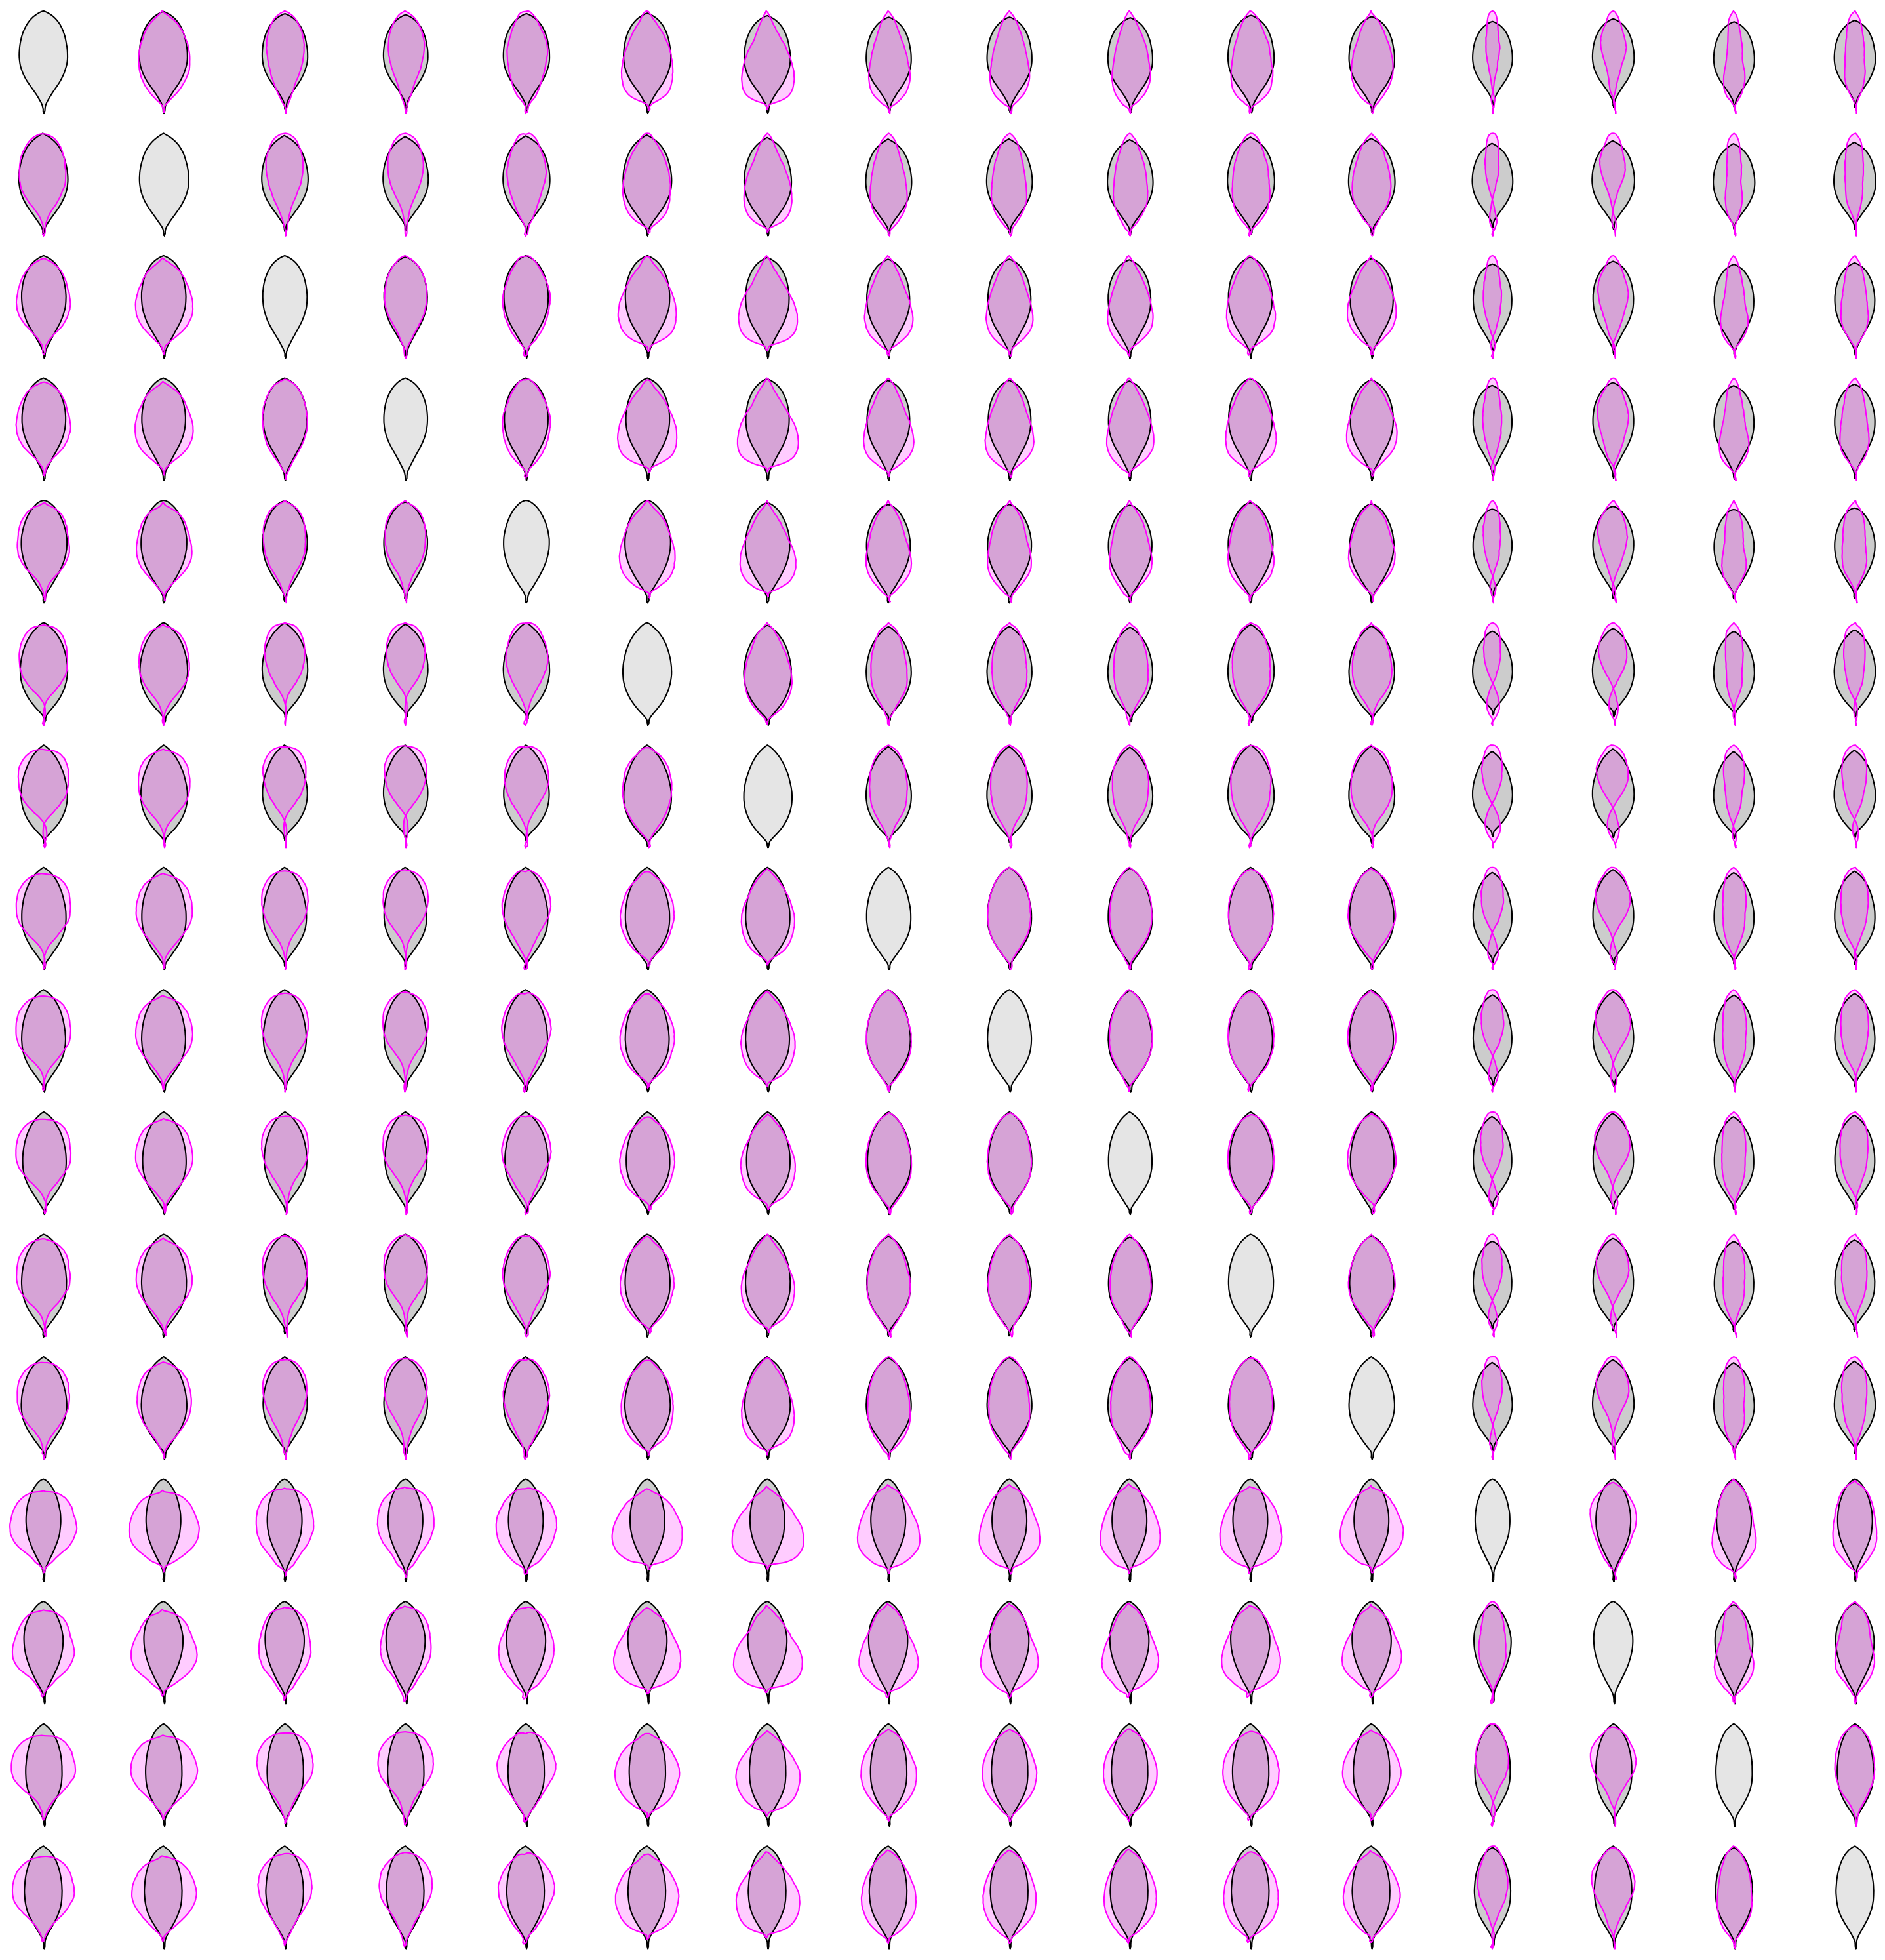

In [47]:
plt.figure(figsize=(30,30))

mag = 3.0

count=1

for first_arr in array_list:
    
    for second_arr in array_list:
        
        difference = np.mean(np.mean(second_arr, axis=0) - np.mean(first_arr, axis=0))
        
        if difference==0:
            plt.subplot(16,16,count)
            plt.fill(np.mean(first_arr, axis=0)[:,0], np.mean(first_arr, axis=0)[:,1], c="gray", alpha=0.2)
            plt.plot(np.mean(first_arr, axis=0)[:,0], np.mean(first_arr, axis=0)[:,1], c="k", alpha=1)
            plt.axis("off")
            plt.gca().set_aspect("equal")
            
            count+=1
            
        else:
            
            plt.subplot(16,16,count)
            plt.fill(np.mean(first_arr, axis=0)[:,0], np.mean(first_arr, axis=0)[:,1], c="k", alpha=0.2)
            plt.plot(np.mean(first_arr, axis=0)[:,0], np.mean(first_arr, axis=0)[:,1], c="k", alpha=1)

            diff_arr = np.mean(second_arr, axis=0) - np.mean(first_arr, axis=0)
            mag_arr = np.mean(first_arr, axis=0) + mag*diff_arr

            plt.plot(mag_arr[:,0], mag_arr[:,1], c="magenta", alpha=1)
            plt.fill(mag_arr[:,0], mag_arr[:,1], c="magenta", alpha=0.2)


            plt.axis("off")
            plt.gca().set_aspect("equal")

            count+=1
        
plt.tight_layout()
        
        

### Prediction of variety type

Confusion matrices and LDA scores were calculated by projecting samples back onto the fitted model for cultivated varieties.

In [60]:
# stack all arrays into one
var_arr = np.row_stack(
    
    (C00_chirosa_arr,
    C01_chiparra_arr,
    I02_trujillense_caucana_arr,
    I03_boliviana_blanca_arr,
    N04_tingo_pajarita_arr,
    C05_guayaba_roja_arr,
    I06_gigante_arr,
    C07_peruana_roja_arr,
    C08_boliviana_roja_arr,
    C09_tingo_peruana_arr,
    C10_dulce_arr,
    I11_amazona_arr,
    N12_tingo_pajarita_caucana_arr,
    T13_crespa_arr,
    C14_tingo_maria_arr,
    C15_patirroja_arr)
    
)

# create a list of names to make into a pandas dataframe
full_name_list = [
    *["C00_chirosa"]*len(C00_chirosa_arr), 
    *["C01_chiparra"]*len(C01_chiparra_arr), 
    *["I02_trujillense_caucana"]*len(I02_trujillense_caucana_arr), 
    *["I03_boliviana_blanca"]*len(I03_boliviana_blanca_arr), 
    *["N04_tingo_pajarita"]*len(N04_tingo_pajarita_arr), 
    *["C05_guayaba_roja"]*len(C05_guayaba_roja_arr), 
    *["I06_gigante"]*len(I06_gigante_arr), 
    *["C07_peruana_roja"]*len(C07_peruana_roja_arr), 
    *["C08_boliviana_roja"]*len(C08_boliviana_roja_arr), 
    *["C09_tingo_peruana"]*len(C09_tingo_peruana_arr), 
    *["C10_dulce"]*len(C10_dulce_arr), 
    *["I11_amazona"]*len(I11_amazona_arr), 
    *["N12_tingo_pajarita_caucana"]*len(N12_tingo_pajarita_caucana_arr), 
    *["T13_crespa"]*len(T13_crespa_arr), 
    *["C14_tingo_maria"]*len(C14_tingo_maria_arr), 
    *["C15_patirroja"]*len(C15_patirroja_arr), 

]

# create pandas dataframe of variety names
var_df = pd.DataFrame({"full_name":full_name_list})

# create a list to order confusion matrix labels
order_list = ["C00_chirosa","C01_chiparra","I02_trujillense_caucana","I03_boliviana_blanca","N04_tingo_pajarita",
              "C05_guayaba_roja","I06_gigante","C07_peruana_roja","C08_boliviana_roja","C09_tingo_peruana","C10_dulce",
              "I11_amazona","N12_tingo_pajarita_caucana","T13_crespa","C14_tingo_maria","C15_patirroja"]

The number of falsely predicted: 2
The number of correctly predicted: 317
Out of 319 total samples


Text(98.0815972222222, 0.5, 'Actual class')

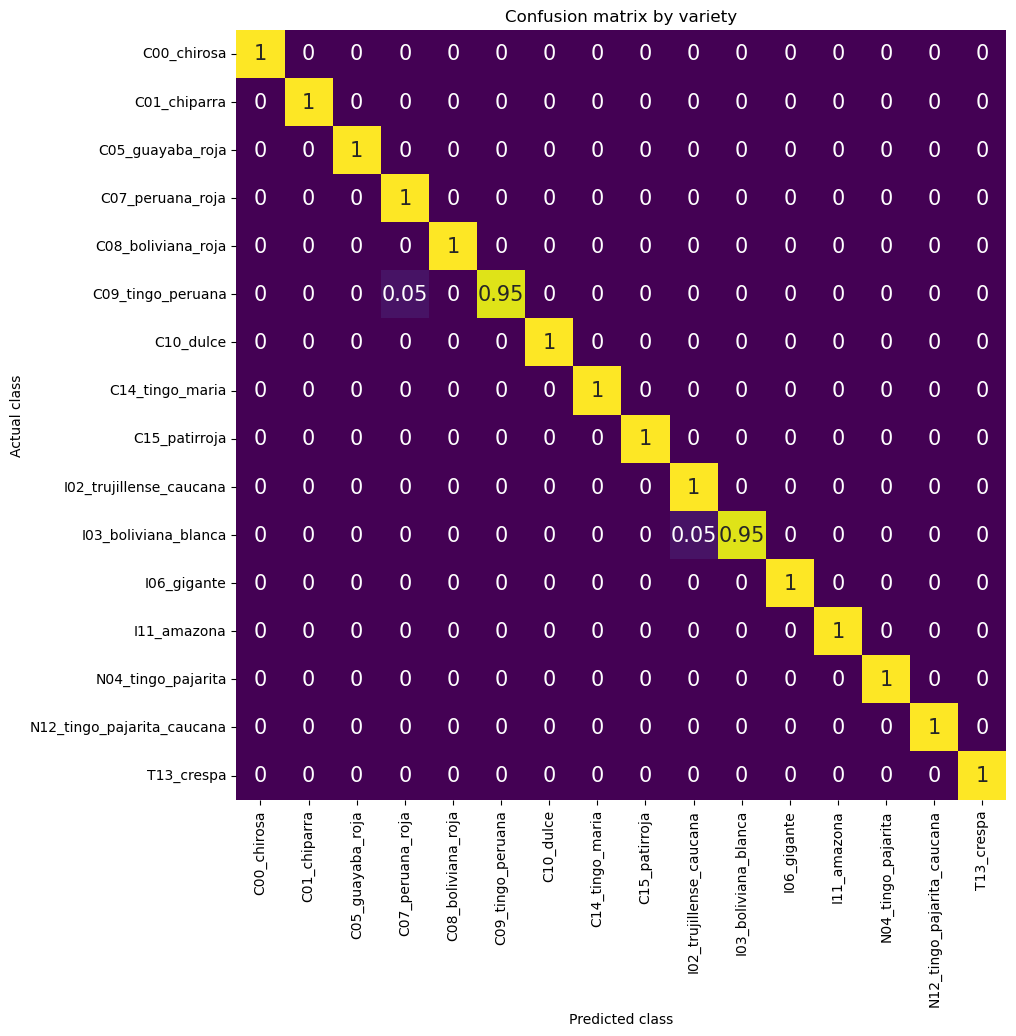

In [67]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# use the reshape function to flatten to 2D
flat_arr = var_arr.reshape(np.shape(var_arr)[0], 
                                 np.shape(var_arr)[1]*np.shape(var_arr)[2]) 

# create a df for LDA by type name
pred_df = pd.DataFrame(data=flat_arr[:,:])

# add the type name labels
pred_df["variety_name"] = var_df["full_name"]

# create input and output variables
X = pred_df.iloc[:,0:((res*2)-1)*2]
y = pred_df["variety_name"]

# fit the LDA model
pred_model = LinearDiscriminantAnalysis()
pred_model.fit(X,y)

# retrieve LDA scalings and coefficients
pred_scalings = pred_model.scalings_
pred_coefs = pred_model.coef_

# perform prediction
pred_prediction = pred_model.predict(X)
comparison_result = [X == y for X, y in zip(y, pred_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_pred_values = var_df["full_name"]
predicted_pred_values = pred_prediction

cm_pred = confusion_matrix(true_pred_values, predicted_pred_values, normalize="true")
          
cm_pred = cm_pred / cm_pred.sum(axis=1)

classes = np.sort(var_df["full_name"].unique())

# Confusion matrix

plt.figure(figsize=(10,10))

sns.heatmap(cm_pred, 
            annot=True, 
            annot_kws={"fontsize":15}, 
            #fmt="d", 
            cmap="viridis", 
            square=True, 
            cbar=False,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by variety")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")


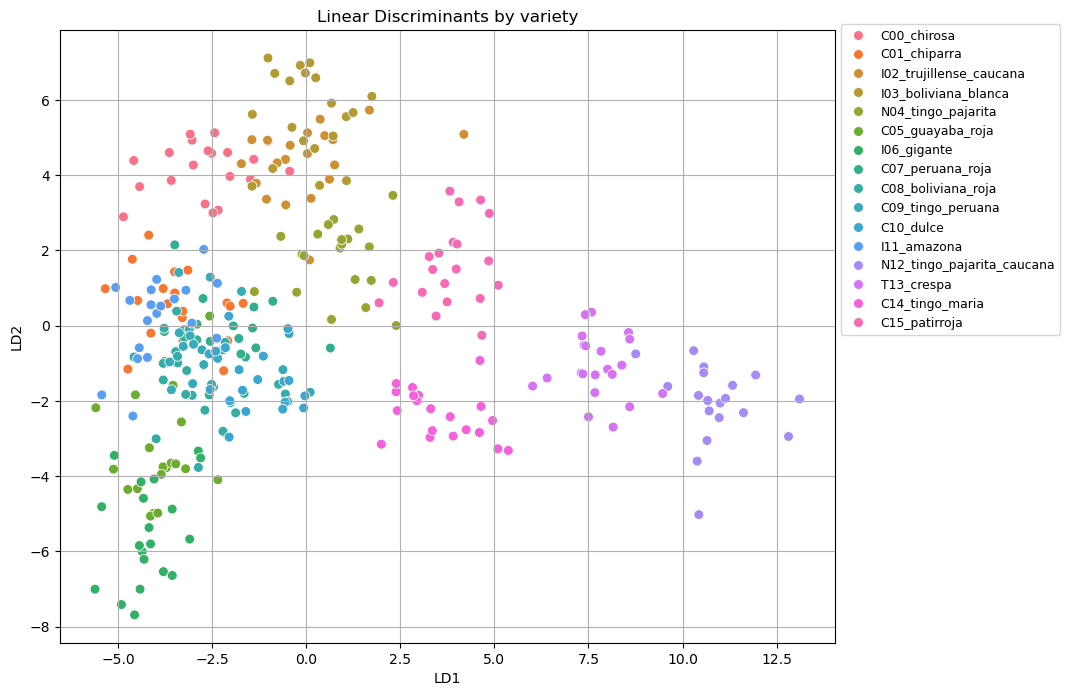

In [66]:
# Plot of linear discriminant scores by type

data_plot = pred_model.fit(X, y).transform(X)
pred_plot_df = pd.DataFrame(data=data_plot[:,:])
pred_plot_df["variety"] = var_df["full_name"]

pred_plot_df = pred_plot_df.rename(columns={0:'LD1', 1:'LD2'})

plt.figure(figsize=(10,10))
sns.scatterplot(data=pred_plot_df, x="LD1", y="LD2", hue="variety", s=50)
plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})

plt.title("Linear Discriminants by variety")
plt.gca().set_aspect("equal")
plt.grid()